### Setup

In [23]:
# !pip install fvgp~=4.3.0
import numpy as np
import matplotlib.pyplot as plt
from fvgp import GP
import time

# %load_ext autoreload
# %autoreload 2

from itertools import product
x_pred1D = np.linspace(0, 1, 1000).reshape(-1, 1)

### Data

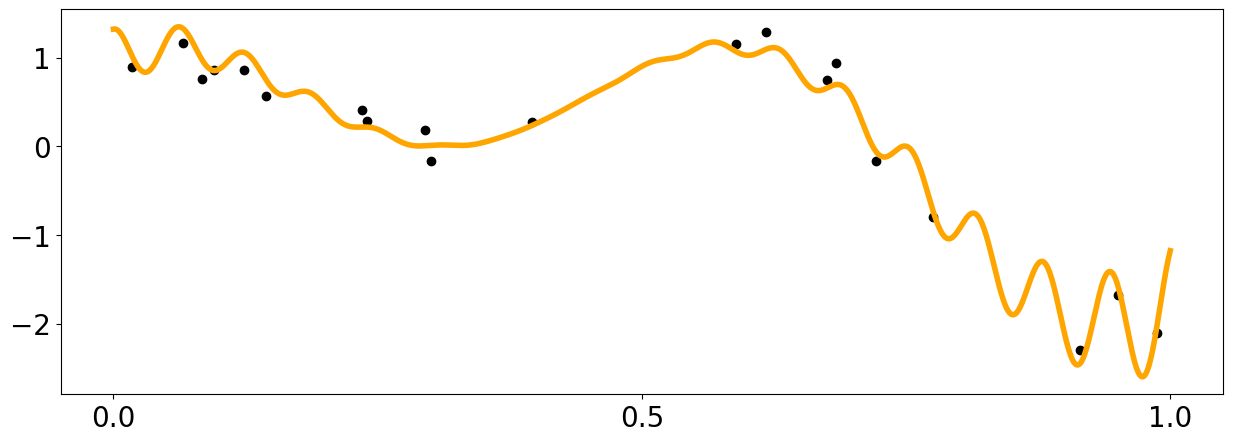

In [24]:
x = np.linspace(0,600,1000)
def f1(x):
    return np.sin(5. *x) + np.cos(10. * x) + (2.* (x-0.4)**2) * np.cos(100. * x)

x_data = np.random.rand(20).reshape(-1,1)
y_data = f1(x_data[:,0]) + (np.random.rand(len(x_data))-0.5) * 0.5

plt.figure(figsize = (15,5))
plt.xticks([0.,0.5,1.0])
plt.yticks([-2,-1,0.,1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(x_pred1D, f1(x_pred1D), color = 'orange', linewidth = 4)
plt.scatter(x_data[:,0],y_data, color = 'black')

In [25]:
# why the orange function always stays the same

### Customizing a Gaussian Process

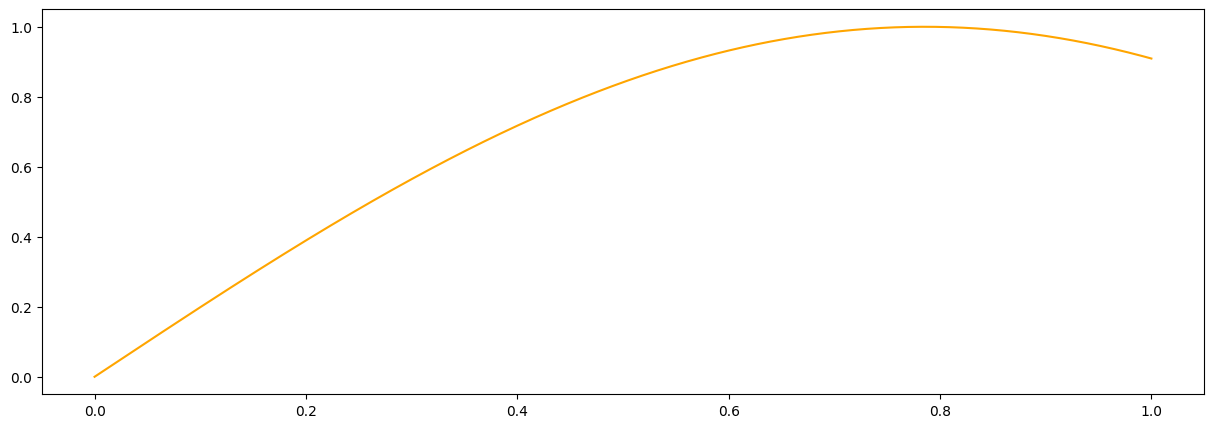

In [26]:
from fvgp.gp_kernels import *


# This is a simple noise function but can be arbitrarily complex using many hyperparameters.
# The noise function always has to return a matrix, because the noise can have covariances.
def my_noise(x, hps):
    return np.diag(np.zeros((len(x))) + hps[2])

# stationary
# The kernel follows the mathematical definition of a kernel. This means
# there is no limit to the variety of kernels you can define
def skernel(x1,x2,hps):
    d = get_distance_matrix(x1,x2)
    return hps[0] * matern_kernel_diff1(d, hps[1])

# This is a simple mean function but it can be arbitrarily complex using many hyperparameters.
def meanf(x,hps):
    return np.sin(hps[3] * x[:,0])


# it is a good idea to plot the prior mean function to make sure we did not mess up
plt.figure(figsize = (15,5))
plt.plot(x_pred1D, meanf(x_pred1D, np.array([1.,1.,5.0,2.])), color = 'orange', label = 'task1')

### Initialization and different training options

In [27]:
my_gp1 = GP(x_data,y_data,
            init_hyperparameters = np.ones((4))/10.,  # we need enough of those for kernel, noise and prior mean functions
            noise_variances=np.ones(y_data.shape) * 0.01, #provding noise variances and a noise function will raise a warning 
            compute_device='cpu', 
            gp_kernel_function=skernel, 
            gp_kernel_function_grad=None, 
            gp_mean_function=meanf, 
            gp_mean_function_grad=None,
            #gp_noise_function=my_noise,
            gp2Scale = False,
            calc_inv=False, 
            ram_economy=False, 
            args=None,
            )

hps_bounds = np.array([[0.01,10.], #signal variance for the kernel
                       [0.01,10.], #length scale for the kernel
                       [0.001,0.1],  #noise
                       [0.01,1.]  #mean
                      ])


my_gp1.update_gp_data(x_data, y_data, noise_variances_new=np.ones(y_data.shape) * 0.01)
print("Standard Training")
my_gp1.train(hyperparameter_bounds=hps_bounds)
print("Global Training")
my_gp1.train(hyperparameter_bounds=hps_bounds, method='global')
print("hps: ", my_gp1.get_hyperparameters())
print("Local Training")
my_gp1.train(hyperparameter_bounds=hps_bounds, method='local')
print(my_gp1.get_hyperparameters())
print("MCMC Training")
my_gp1.train(hyperparameter_bounds=hps_bounds, method='mcmc', max_iter=1000)
print("HGDL Training")
print(my_gp1.get_hyperparameters())
my_gp1.train(hyperparameter_bounds=hps_bounds, method='hgdl', max_iter=10)


Standard Training
Global Training
hps:  [1.16061292 0.07001443 0.07787089 0.01000537]
Local Training
[1.15942312 0.0699446  0.05171655 0.01      ]
MCMC Training
HGDL Training
[2.07605899 0.10315887 0.06205881 0.54256994]


array([1.50851514, 0.08611431, 0.00900826, 0.01      ])

### The Result

0.2820343467828396
(1.060526327491706, 0.9311815423030065)


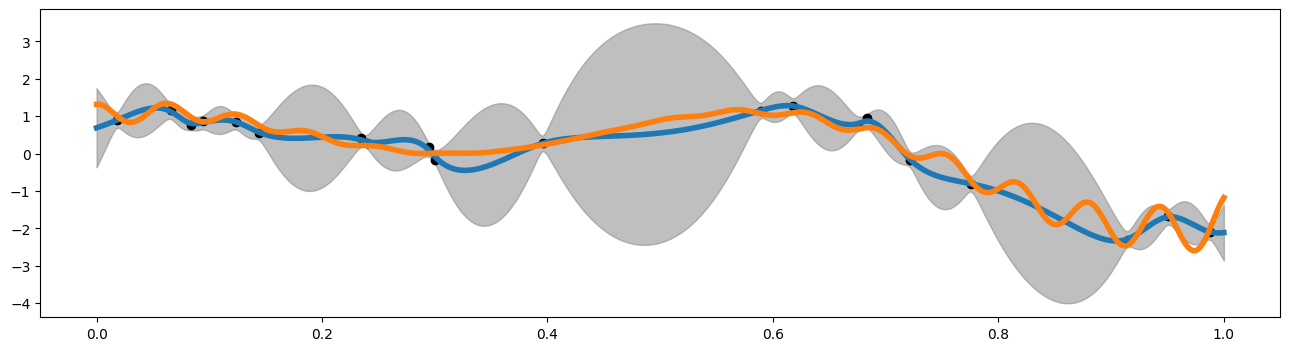

In [28]:
# Let's make a prediction
x_pred = np.linspace(0,1,1000)

mean1 = my_gp1.posterior_mean(x_pred.reshape(-1,1))['f(x)']
var1 = my_gp1.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=False)['v(x)']
var1 = my_gp1.posterior_covariance(x_pred.reshape(-1,1), variance_only=True, add_noise=False)['v(x)']

mean1 = my_gp1.posterior_mean(x_pred.reshape(-1,1))['f(x)']
var1 = my_gp1.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=True)['v(x)']
plt.figure(figsize = (16,4))
plt.plot(x_pred, mean1, label = 'posterior mean', linewidth = 4)
plt.plot(x_pred1D, f1(x_pred1D), label = 'latent function', linewidth = 4)
plt.fill_between(x_pred, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = 'grey', label = 'var')
plt.scatter(x_data, y_data, color = 'black')

# looking at some validation metrics
print(my_gp1.rmse(x_pred1D, f1(x_pred1D)))
print(my_gp1.crps(x_pred1D, f1(x_pred1D)))

### Predicted Information Gain

In [77]:
relative_entropy = my_gp1.gp_relative_information_entropy_set(x_pred.reshape(-1,1))['RIE']

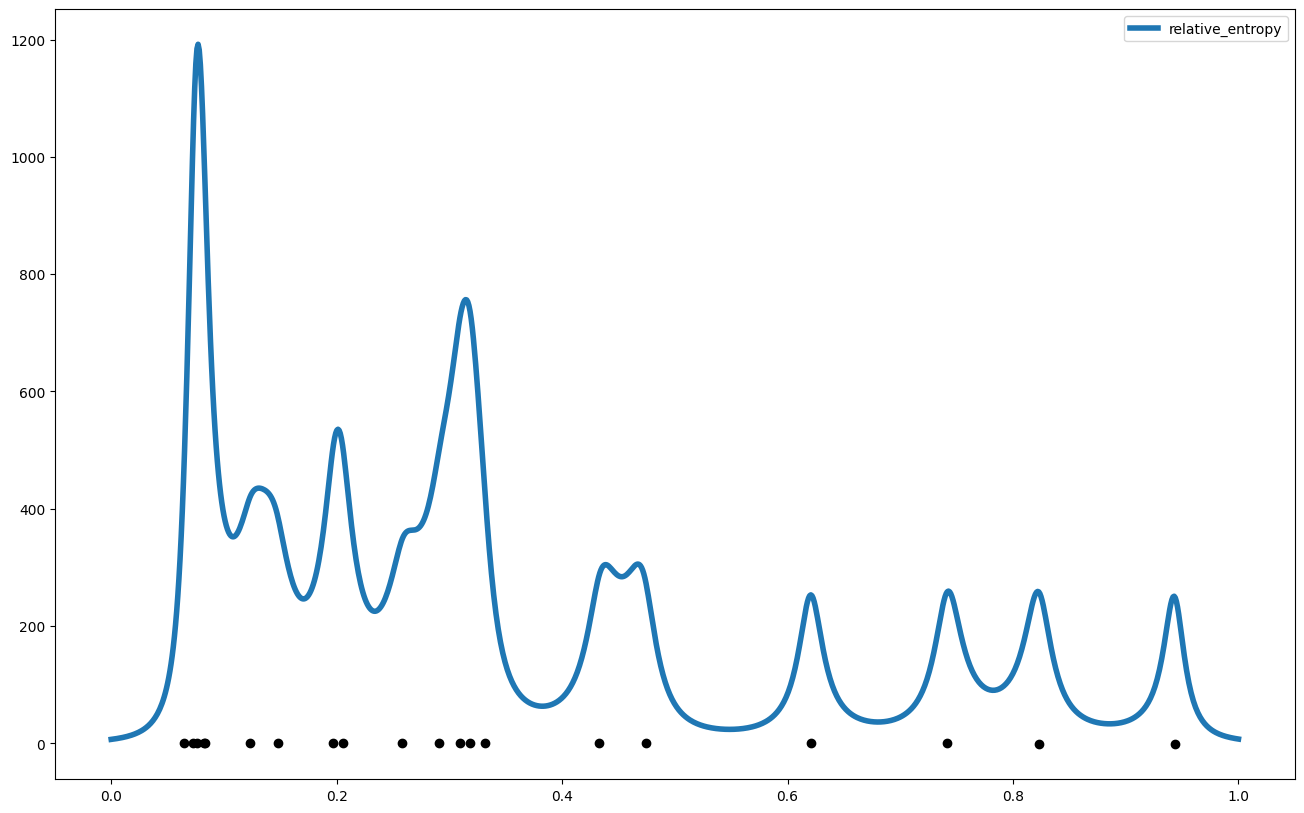

In [78]:
plt.figure(figsize = (16,10))
plt.plot(x_pred, relative_entropy, label =  'relative_entropy', linewidth = 4)
plt.scatter(x_data, y_data, color = 'black')
plt.legend()

In [84]:
# We can ask mutual inforation and total correlation there is given some test data
x_test = np.array([[0.45],[0.45]])
print('MI: ', my_gp1.gp_mutual_information(x_test))
print('TC: ',my_gp1.gp_total_correlation(x_test))
my_gp1.gp_entropy(x_test)
my_gp1.gp_entropy_grad(x_test, 0)
my_gp1.gp_kl_div(x_test, np.ones((len(x_test))), np.identity((len(x_test))))
my_gp1.gp_kl_div_grad(x_test, np.ones((len(x_test))), np.identity((len(x_test))), 0)
my_gp1.gp_relative_information_entropy(x_test)
my_gp1.gp_relative_information_entropy_set(x_test)
my_gp1.posterior_covariance(x_test)
my_gp1.posterior_covariance_grad(x_test)
my_gp1.posterior_mean(x_test)
my_gp1.posterior_mean_grad(x_test)
my_gp1.posterior_probability(x_test, np.ones((len(x_test))), np.identity((len(x_test))))
my_gp1.posterior_probability_grad(x_test, np.ones((len(x_test))), np.identity((len(x_test))),0)


MI:  {'x': array([[0.45],
       [0.45]]), 'mutual information': 3.6985943968886374}
TC:  {'x': array([[0.45],
       [0.45]]), 'total correlation': 14.172526991022913}


{'probability grad': 1.2945081867415942}